## Spectrum and Spectrogram

Inspired by https://mark-kramer.github.io/Case-Studies-Python/03.html

In [1]:
##how to structure data: mat_data_t['key'][first set][wrap][r]
import scipy.io
import os
import h5py


In [2]:
import scipy.io
import os
import h5py
from mne import create_info
from mne.io import RawArray
import numpy as np
import pandas as pd
import mne
import pandas as pd
import matplotlib.pyplot as plt

#### Setup of Data and Spectrogram setup

In [3]:

mat_data_d = scipy.io.loadmat('Trial_1.mat')
mat_array_d = mat_data_d['currentTable']
mat_array_without_t = mat_array_d[2:]

nchannels, nsamples = mat_array_without_t.shape
label = np.array([f"A-{str(i).zfill(3)}" for i in range(nchannels)])
sfreq = 30000

print(nchannels)
print(nsamples)
print(label)

info = mne.create_info(nchannels,sfreq=sfreq, ch_types='ecog')

100
169800
['A-000' 'A-001' 'A-002' 'A-003' 'A-004' 'A-005' 'A-006' 'A-007' 'A-008'
 'A-009' 'A-010' 'A-011' 'A-012' 'A-013' 'A-014' 'A-015' 'A-016' 'A-017'
 'A-018' 'A-019' 'A-020' 'A-021' 'A-022' 'A-023' 'A-024' 'A-025' 'A-026'
 'A-027' 'A-028' 'A-029' 'A-030' 'A-031' 'A-032' 'A-033' 'A-034' 'A-035'
 'A-036' 'A-037' 'A-038' 'A-039' 'A-040' 'A-041' 'A-042' 'A-043' 'A-044'
 'A-045' 'A-046' 'A-047' 'A-048' 'A-049' 'A-050' 'A-051' 'A-052' 'A-053'
 'A-054' 'A-055' 'A-056' 'A-057' 'A-058' 'A-059' 'A-060' 'A-061' 'A-062'
 'A-063' 'A-064' 'A-065' 'A-066' 'A-067' 'A-068' 'A-069' 'A-070' 'A-071'
 'A-072' 'A-073' 'A-074' 'A-075' 'A-076' 'A-077' 'A-078' 'A-079' 'A-080'
 'A-081' 'A-082' 'A-083' 'A-084' 'A-085' 'A-086' 'A-087' 'A-088' 'A-089'
 'A-090' 'A-091' 'A-092' 'A-093' 'A-094' 'A-095' 'A-096' 'A-097' 'A-098'
 'A-099']


In [4]:
#setup of MNE structure

raw = mne.io.RawArray(mat_array_without_t, info)
referenced_raw, _ = mne.set_eeg_reference(raw, ref_channels='average', copy=True, ch_type='ecog')

Creating RawArray with float64 data, n_channels=100, n_times=169800
    Range : 0 ... 169799 =      0.000 ...     5.660 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.


In [122]:
iir_params = dict(order=6, ftype='butter', output='sos')
#raw_notch = referenced_raw.copy().notch_filter(freqs=(50,100,150,200, 250), method='fir') #applies a  remove or attenuate specific frequencies from the data. In this case, it targets frequencies at 50 Hz, 100 Hz, 150 Hz, 200 Hz, and 250 Hz.  notch filter to the 
#raw_notch = referenced_raw.copy().notch_filter(freqs=50, method='iir', iir_params=iir_params)

filt_low, filt_high = 100, 300
raw_bandpass = referenced_raw.copy().filter(l_freq=filt_low, h_freq=filt_high, method='iir') #The bandpass filter allows only frequencies within the specified range (0 Hz to 300 Hz) to pass through while attenuating frequencies outside this range

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1e+02 - 3e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 100.00, 300.00 Hz: -6.02, -6.02 dB



Effective window size : 4.000 (s)


/var/folders/bk/w50dtr693qq9dmmc6bbthfqc0000gn/T/ipykernel_61087/762763263.py:3: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  raw_bandpass.compute_psd(method="welch",fmax=200,n_fft=int(4*sfreq)).plot(average=True)
/Users/emmatoh/miniforge3/lib/python3.9/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


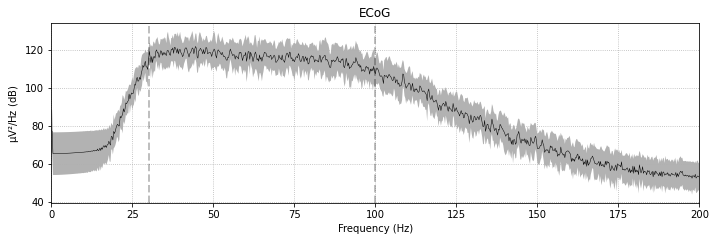

In [36]:
import matplotlib.pyplot as plt

raw_bandpass.compute_psd(method="welch",fmax=300,n_fft=int(4*sfreq)).plot(average=True)
plt.show()


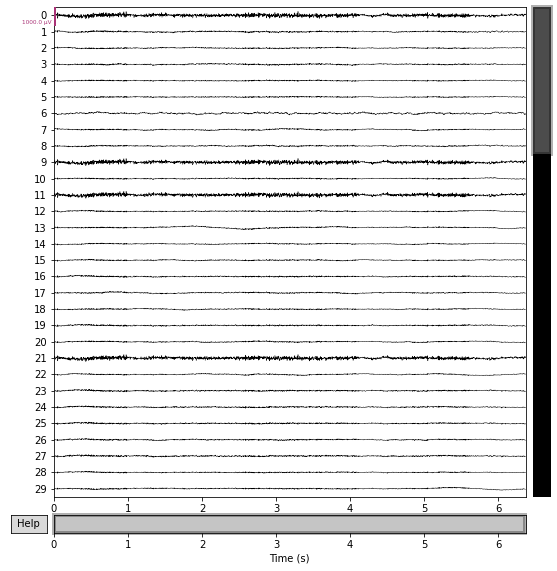

(<MNEBrowseFigure size 576x576 with 4 Axes>, None)

In [128]:
rb = raw_bandpass.copy()
rb._data*=1e-6
rb.plot(scalings=dict(ecog=500*1e-6),duration=60*5,n_channels=30),plt.show()

### Spectrogram plotting

In [179]:
W = 1

psds_raw_100_300=raw_bandpass.compute_psd(method="welch",tmin=0, tmax=W, fmin=100,fmax=300, 
                                  n_fft=int(W*sfreq), verbose=1).to_data_frame().set_index('freq').mean(axis=1)


for offset in np.arange (1, int (600/W),1): # start time and end time, in s
    try:
        print(offset, end=" ",flush=True)
        psds_raw_100_300 = pd.concat ([psds_raw_100_300, raw_bandpass.compute_psd(method= "welch",tmin=0+offset,tmax=W+offset,
                                                                  fmin=100, fmax=300,n_fft=int (W*sfreq),
                                                                  verbose=0).to_data_frame().set_index('freq').mean(axis=1)],axis=1)
    except Exception as e:
        print(f"Array ended at offset {offset}: {e}")
        break



Effective window size : 1.000 (s)
Spectogram using 30000-point FFT on 30000 samples with 0 overlap and hamming window
1 2 3 4 5 Array ended at offset 5: If n_per_seg is None n_fft is not allowed to be > n_times. If you want zero-padding, you have to set n_per_seg to relevant length. Got n_fft of 30000 while signal length is 19800.


Shape: (201, 5)


(100.0, 300.0)

<Figure size 1200x400 with 0 Axes>

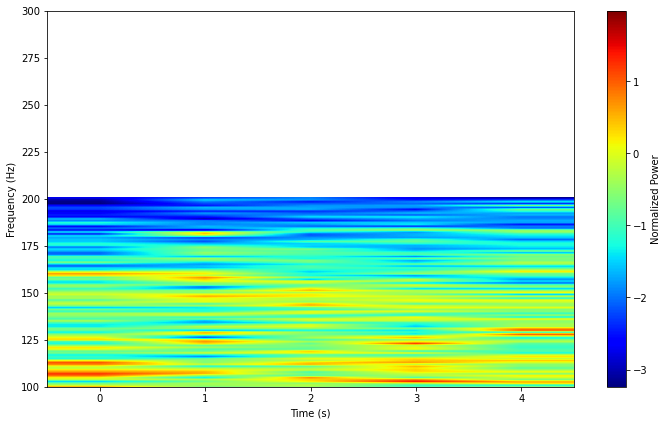

In [15]:
import matplotlib.pyplot as plt
print(f'Shape: {psds_raw.shape}')

%matplotlib inline

plt.figure(figsize=(6,2), dpi=200)


fig, ax1 = plt.subplots(figsize=(10, 6))

# Normalized to relative power band
plt.imshow(np.log(psds_raw.divide(psds_raw.mean())), aspect='auto', cmap='jet', origin= 'lower',
           interpolation='bilinear',extent=[0, psds_raw.shape[1], psds_raw.index[0], psds_raw.index[-1]])

plt.ylabel('Frequency (Hz)'), plt.xlabel ('Time (s)') 
plt.tight_layout()
colorbar = plt.colorbar ()
colorbar.set_label('Normalized Power')
plt.ylim([100,300])
#plt.plot(pd.Series(ds_velocity).rolling (5).mean()/3, c='k', Lw=1) plt.show(

## ADDING trajectories to the plot

In [186]:
traj_data = pd.read_csv('181214_S6_Trial_9.csv')
mat_data_d = scipy.io.loadmat('table_9.mat')
mat_array_d = mat_data_d['currentTable']

In [184]:
# Analyse the first timing differences between the traj file and the signal plot file
folder_path_csv = '
folder_path_mat = ''

# Get a list of all CSV files in the first folder
csv_files = [file for file in os.listdir(folder_path_csv) if file.endswith('.csv')]

# Get a list of all MAT files in the second folder
mat_files = [file for file in os.listdir(folder_path_mat) if file.endswith('.mat')]

# Sort the lists to ensure files are in the same order
csv_files.sort()
mat_files.sort()

# Loop through each pair of files and perform the operation
for csv_file, mat_file in zip(csv_files, mat_files):
    # Read CSV file
    traj_data = pd.read_csv(os.path.join(folder_path_csv, csv_file))
    traj_first_time = traj_data.iloc[1,2]

    # Read MAT file (assuming it contains a variable 'timing' in the first column)
    mat_data_d = scipy.io.loadmat(os.path.join(folder_path_mat, mat_file))
    mat_array_d = mat_data_d['currentTable']
    mat_first_time = mat_array_d[1][0]

    # Perform the operation (subtract timings)
    result = traj_first_time - mat_first_time

    # Print or use the result as needed
    print(f"Result for {csv_file} - {mat_file}: {result}")


Result for 181214_S6_Trial_1.csv - table_1.mat: 0.10296666666427612
Result for 181214_S6_Trial_10.csv - table_10.mat: 0.10296666666766896
Result for 181214_S6_Trial_12.csv - table_12.mat: 0.1999666666636699
Result for 181214_S6_Trial_13.csv - table_13.mat: 0.101966666666641
Result for 181214_S6_Trial_14.csv - table_14.mat: 0.4049666666666667
Result for 181214_S6_Trial_15.csv - table_15.mat: 0.10196666666868737
Result for 181214_S6_Trial_3.csv - table_3.mat: 0.10196666666436727
Result for 181214_S6_Trial_4.csv - table_4.mat: 0.098966666668872
Result for 181214_S6_Trial_7.csv - table_7.mat: 0.10196666666367094
Result for 181214_S6_Trial_8.csv - table_8.mat: 0.1019666666646799
Result for 181214_S6_Trial_9.csv - table_9.mat: -3.3333332339680055e-05


Shape: (201, 10)


(0.0, 10.308966666666663)

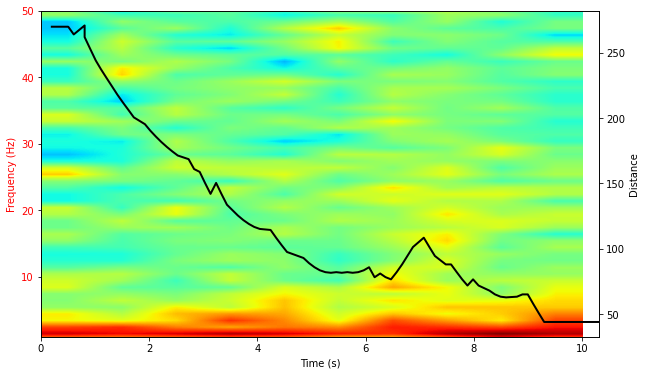

In [236]:
import matplotlib.pyplot as plt
print(f'Shape: {psds_raw.shape}')

%matplotlib inline

#### Load the spectrogram as per normal first


fig, ax1 = plt.subplots(figsize=(10, 6))

# Normalized to relative power band
ax1.imshow(np.log(psds_raw.divide(psds_raw.mean())), aspect='auto', cmap='jet', origin= 'lower',
           interpolation='bilinear',extent=[0, psds_raw.shape[1], psds_raw.index[0], psds_raw.index[-1]])

ax1.set_ylabel('Frequency (Hz)',color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_xlabel ('Time (s)') 
ax1.set_ylim([1,50])


#plt.plot(pd.Series(ds_velocity).rolling (5).mean()/3, c='k', Lw=1) plt.show

# Specify the CSV file of trajectories to plot
traj_data = pd.read_csv('181214_S6_Trial_9.csv')

x_diff = traj_data['refX'] - traj_data['x']
y_diff = traj_data['refY'] - traj_data['y']
euclidean_distance = np.sqrt(x_diff**2 + y_diff**2)

ax2 = ax1.twinx()

mat_first_time = mat_array_d[1][0]  # Assuming the timing is in the third column of the second row
filtered_traj_data = traj_data[traj_data['timing'] >= mat_first_time]
end_time = mat_array_d[1, -1] - mat_first_time

ax2.plot(filtered_traj_data['timing'] - mat_first_time, euclidean_distance.loc[filtered_traj_data.index], '-k', linewidth=2,
         label='Euclidean Distance (Red)')  # Red line
ax2.set_ylabel('Distance', color='k')  # Right y-axis label for the other variable
ax2.tick_params(axis='y', labelcolor='k')
ax1.set_xlim([0, end_time])


## Code to Generate Grid of Spectrogram and Plotted Trajectories

In [ ]:
import scipy.io
import os
import h5py
from mne import create_info
from mne.io import RawArray
import numpy as np
import pandas as pd
import mne
import pandas as pd
import matplotlib.pyplot as plt

W = 1

fig, ax1 = plt.subplots(figsize=(15, 10)) 

In [48]:
## NEED TO CHANGE the uphz and the 300
# Path to the folder containing CSV files
folder_path_csv = ''
folder_path_mat = ''

# Get a list of all CSV files in the first folder
csv_files = [file for file in os.listdir(folder_path_csv) if file.endswith('.csv')]

# Get a list of all MAT files in the second folder
mat_files = [file for file in os.listdir(folder_path_mat) if file.endswith('.mat')]

# Sort the lists to ensure files are in the same order
csv_files.sort()
mat_files.sort()

uphz = 300 ## CHANGE WHEN NEEDED TO SUIT EACH Hz

# Set up a 3x4 grid for subplots
fig, axs = plt.subplots(10, 4, figsize=(120, 90)) #change the number in case there is a large number of trials in each session
fig.suptitle('Spectrogram Plots for 5s3 Trials 0 to 300') ##RENAME THE FILE
    
for i, (csv_file, mat_file) in enumerate(zip(csv_files, mat_files)):
    # Calculate the subplot position
    
    row = i // 4
    col = i % 4
    
    mat_data_d = scipy.io.loadmat(os.path.join(folder_path_mat, mat_file))
    mat_array_d = mat_data_d['currentTable']
    mat_array_without_t = mat_array_d[2:]
    mat_first_time = mat_array_d[1][0]
    nchannels, nsamples = mat_array_without_t.shape
    label = np.array([f"A-{str(i).zfill(3)}" for i in range(nchannels)])
    sfreq = 30000
    
    traj_data = pd.read_csv(os.path.join(folder_path_csv, csv_file))
    traj_first_time = traj_data.iloc[1,2]
    
    info = mne.create_info(nchannels,sfreq=sfreq, ch_types='ecog')
    
    #setup of MNE structure
    raw = mne.io.RawArray(mat_array_without_t, info)
    referenced_raw, _ = mne.set_eeg_reference(raw, ref_channels='average', copy=True, ch_type='ecog')
    
    raw_notch = referenced_raw.copy().notch_filter(freqs=50, method='iir', iir_params=iir_params)

    filt_low, filt_high = 0, uphz
    raw_bandpass = raw_notch.copy().filter(l_freq=filt_low, h_freq=filt_high, method='iir') #The bandpass filter allows only frequencies within the specified range (0 Hz to 300 Hz) to pass through while attenuating frequencies outside this range

    # Read the CSV file into a DataFram
    psds_raw = raw_bandpass.compute_psd(method="welch", tmin=0, tmax=W, fmin=0, fmax=uphz,
                                       n_fft=int(W * sfreq), verbose=1).to_data_frame().set_index('freq').mean(axis=1)
    
    
    for offset in np.arange (1, int (600/W),1): # start time and end time, in s
        try:
            print(offset, end=" ",flush=True)
            psds_raw = pd.concat ([psds_raw, raw_bandpass.compute_psd(method= "welch",tmin=0+offset,tmax=W+offset,
                                                                  fmin=0, fmax=uphz,n_fft=int (W*sfreq),
                                                                  verbose=0).to_data_frame().set_index('freq').mean(axis=1)],axis=1)
        except Exception as e:
            print(f"Array ended at offset {offset}: {e}")
            break
    
    print(f"i: {i}, row: {row}, col: {col}")
    
    # Plot the spectrogram on the specified subplot
    axs[row, col].imshow(np.log(psds_raw.divide(psds_raw.mean())), aspect='auto', cmap='jet', origin='lower',
                         interpolation='bilinear',extent=[0, psds_raw.shape[1], psds_raw.index[0], psds_raw.index[-1]])
    
    axs[row, col].set_title(mat_file)
    
    axs[row, col].set_ylim([0, 50]) #change the y-axes limits if necessary, eg change to 50 vs uphz 
    axs[row, col].set_ylabel('Frequency (Hz)',color='r')
    axs[row, col].tick_params(axis='y', labelcolor='r')
    axs[row, col].set_xlabel ('Time (s)') 
    
    x_diff = traj_data['refX'] - traj_data['x']
    y_diff = traj_data['refY'] - traj_data['y']
    euclidean_distance = np.sqrt(x_diff**2 + y_diff**2)
    
    ax2 = axs[row, col].twinx()
    filtered_traj_data = traj_data[traj_data['timing'] >= mat_first_time]
    end_time = mat_array_d[1, -1] - mat_first_time
    
    ax2.plot(filtered_traj_data['timing'] - mat_first_time, euclidean_distance.loc[filtered_traj_data.index], '-k', linewidth=2,
         label='Euclidean Distance (Red)')  # Red line
    ax2.set_ylabel('Distance', color='k')  # Right y-axis label for the other variabl
    ax2.tick_params(axis='y', labelcolor='k')
    ax1.set_xlim([0, end_time])


# Adjust layout to prevent clipping of titles
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()


Creating RawArray with float64 data, n_channels=100, n_times=178890
    Range : 0 ... 178889 =      0.000 ...     5.963 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3e+02 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 300.00 Hz: -6.02 dB

Effective window size : 1.000 (s)
Spectogram using 30000-point FFT on 30000 samples with 0 overlap and hamming window
1 2 3 4 5 Array ended at offset 5: If n_per_seg is None n_fft is not allow

    Range : 0 ... 172739 =      0.000 ...     5.758 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3e+02 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 300.00 Hz: -6.02 dB

Effective window size : 1.000 (s)
Spectogram using 30000-point FFT on 30000 samples with 0 overlap and hamming window
1 2 3 4 5 Array ended at offset 5: If n_per_seg is None n_fft is not allowed to be > n_times. If you want zero-padding, you have to set n_per_

Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3e+02 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 300.00 Hz: -6.02 dB

Effective window size : 1.000 (s)
Spectogram using 30000-point FFT on 30000 samples with 0 overlap and hamming window
1 2 3 4 5 Array ended at offset 5: If n_per_seg is None n_fft is not allowed to be > n_times. If you want zero-padding, you have to set n_per_seg to relevant length. Got n_fft of 30000 while signal l

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3e+02 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 300.00 Hz: -6.02 dB

Effective window size : 1.000 (s)
Spectogram using 30000-point FFT on 30000 samples with 0 overlap and hamming window
1 2 3 4 5 Array ended at offset 5: If n_per_seg is None n_fft is not allowed to be > n_times. If you want zero-padding, you have to set n_per_seg to relevant length. Got n_fft of 30000 while signal length is 16710.
i: 21, row: 5, col: 1
Creating RawArray with float64 data,


IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3e+02 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 300.00 Hz: -6.02 dB

Effective window size : 1.000 (s)
Spectogram using 30000-point FFT on 30000 samples with 0 overlap and hamming window
1 2 3 4 5 Array ended at offset 5: If n_per_seg is None n_fft is not allowed to be > n_times. If you want zero-padding, you have to set n_per_seg to relevant length. Got n_fft of 30000 while signal length is 19830.
i: 28, row: 7, col: 0
Creating RawArray with float64 data, n_channels=100, n_times=163770
    Range : 0 ... 163769 =      0.000 ...     5.459 sec

Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 3e+02 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 300.00 Hz: -6.02 dB

Effective window size : 1.000 (s)
Spectogram using 30000-point FFT on 30000 samples with 0 overlap and hamming window
1 2 3 4 5 Array ended at offset 5: If n_per_seg is None n_fft is not allowed to be > n_times. If you want zero-padding, you have to set n_per_seg to relevant length. Got n_fft of 30000 while signal length is 22830.
i: 35, row: 8, col: 3
Creating RawArray with float64 data, n_channels=100, n_times=169800
    Range : 0 ... 169799 =      0.000 ...     5.660 secs
Ready.
Applying average reference.
Applying